## II.5. Exponential Smoothing Methods

**Exponential Smoothing** (ES) is a family of forecasting methods that produce forecasts based on **weighted averages** of **past observations**, with the __weights decaying exponentially__ as the observations get older. 

In other words, more recent observations are given more weight in forecasting than older observations.

These methods can be seen as a form of [state-space model](https://en.wikipedia.org/wiki/State-space_representation), where each model has an equation for the level, and potentially for trend and seasonality. The models estimate these components, which are not directly observed, and use them to produce forecasts.

### II.5.A. Simple Exponential Smoothing (SES)


This is the most basic form of ES, suitable for data with **no trend or seasonality**. It has a single smoothing parameter, $\alpha$ (alpha), for the level component.

-   **Forecast Equation**: $\hat{y}_{t+h|t} = l_t$
-   **Level Equation**: $l_t = \alpha y_t + (1-\alpha) l_{t-1}$

The forecast for all future periods is a flat line equal to the last estimated level, $l_t$.


In [1]:
from utils import plot_series
from matplotlib import pyplot as plt
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.base import ForecastingHorizon
from sktime.datasets import load_airline

In [2]:
y = load_airline()

fh = ForecastingHorizon(y.index, is_relative=False)
forecaster = ExponentialSmoothing(trend=None, seasonal=None)

forecaster.fit(y)
y_sse = forecaster.predict(fh)

forecaster._fitted_forecaster._results._params_formatted

,name,param,optimized
smoothing_level,alpha,1.000000,True
initial_level,l.0,112.000002,True


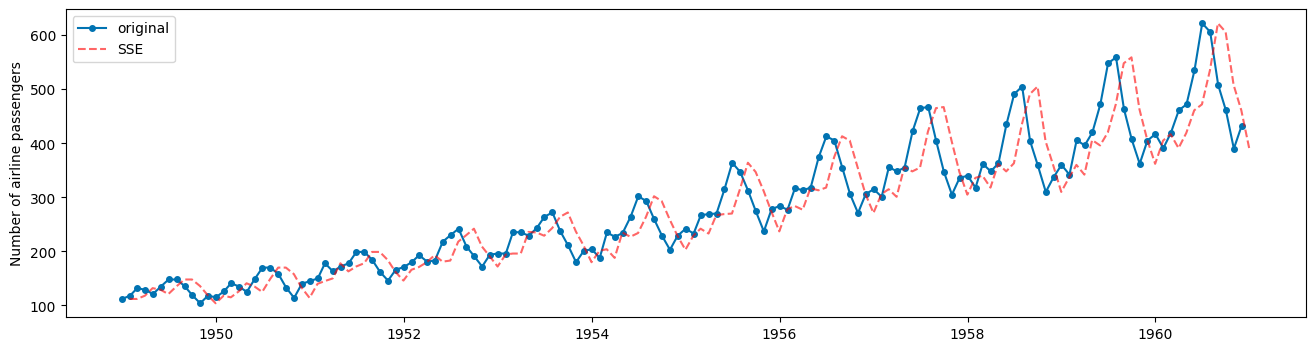

In [3]:
fig, ax = plot_series(y, labels=["original"])
ax.plot(y_sse,color="red", linestyle="--", alpha=0.6,label="SSE")
plt.legend()
plt.show()

### II.5.B. Holt's Methods for trend

Holt (1957) extended Simple Exponential Smoothing to allow for the forecasting of data with a trend. These methods include a second smoothing parameter, $\beta^*$ (beta star), for the trend component.


#### a. Holt's linear trend (HLT) model

This method assumes the trend is linear and will continue to increase or decrease indefinitely.

##### Additive trend
-   **Level**: $l_t = \alpha y_t + (1-\alpha)(l_{t-1} + b_{t-1})$
-   **Trend**: $b_t = \beta(l_t - l_{t-1}) + (1-\beta)b_{t-1}$
-   **Forecast**: $\hat{y}_{t+h|t} = l_t + h \cdot b_t$

In [4]:
y = load_airline()

fh = ForecastingHorizon(y.index, is_relative=False)
forecaster = ExponentialSmoothing(trend="add")

forecaster.fit(y)
y_hlt_a = forecaster.predict(fh)

forecaster._fitted_forecaster._results._params_formatted

,name,param,optimized
smoothing_level,alpha,0.995000,True
smoothing_trend,beta,0.000100,True
initial_level,l.0,118.466667,True
initial_trend,b.0,2.060606,True


##### Multiplicative trend
- **Level**: $l_t = \alpha y_t + (1-\alpha)(l_{t-1} \cdot b_{t-1})$
- **Trend**: $b_t = \beta \frac{l_t}{l_{t-1}} + (1-\beta)b_{t-1}$
- **Forecast**: $\hat{y}_{t+h|t} = l_t \cdot b_t^h$

In [5]:
y = load_airline()

fh = ForecastingHorizon(y.index, is_relative=False)
forecaster = ExponentialSmoothing(trend="mul")

forecaster.fit(y)
y_hlt_m = forecaster.predict(fh)

forecaster._fitted_forecaster._results._params_formatted

,name,param,optimized
smoothing_level,alpha,0.995000,True
smoothing_trend,beta,0.000100,True
initial_level,l.0,118.466667,True
initial_trend,b.0,1.017394,True


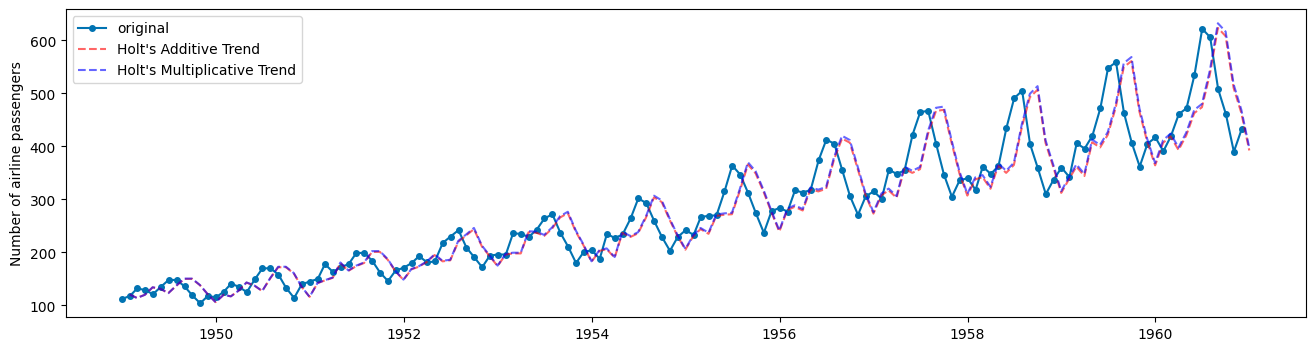

In [6]:
fig, ax = plot_series(y, labels=["original"])
ax.plot(y_hlt_a, color="red", linestyle="--", alpha=0.6,label="Holt's Additive Trend")
ax.plot(y_hlt_m, color="blue", linestyle="--", alpha=0.6,label="Holt's Multiplicative Trend")
plt.legend()
plt.show()

#### b. Holt's damped trend (HDT) method

Holt's linear method can often over-forecast, especially for longer horizons. The damped trend method introduces a damping parameter, $\phi$ (phi), with $0 < \phi < 1$, which dampens the trend over time.

The Level and Trend equations are the same as Holt's linear method. The Forecast equation is modified:

##### Additive trend
-   **Level**: $l_t = \alpha y_t + (1-\alpha)(l_{t-1} + b_{t-1})$
-   **Trend**: $b_t = \beta(l_t - l_{t-1}) + (1-\beta)b_{t-1}$
-   **Forecast**: $\hat{y}_{t+h|t} = l_t + (\phi + \phi^2 + \dots + \phi^h)b_t$

In [7]:
y = load_airline()

fh = ForecastingHorizon(y.index, is_relative=False)
forecaster = ExponentialSmoothing(trend="add", damped_trend=True)

forecaster.fit(y)
y_hdt_a = forecaster.predict(fh)

forecaster._fitted_forecaster._results._params_formatted

,name,param,optimized
smoothing_level,alpha,0.995000,True
smoothing_trend,beta,0.000100,True
initial_level,l.0,118.466667,True
initial_trend,b.0,2.040000,True
damping_trend,phi,0.990000,True


##### Multiplicative trend
- **Level**: $l_t = \alpha y_t + (1-\alpha)(l_{t-1} \cdot b_{t-1})$
- **Trend**: $b_t = \beta \frac{l_t}{l_{t-1}} + (1-\beta)b_{t-1}$
- **Forecast**: $\hat{y}_{t+h|t} = \hat{y}_{t+h|t} = l_t \cdot b_t^{\left(\sum_{i=1}^{h} \phi^i\right)}$

The forecast is generated by multiplying the last level ($l_t$) by the trend factor ($b_t$) raised to a power that is the sum of a damped geometric series. As the forecast horizon $h$ increases, the exponent $\sum_{i=1}^{h} \phi^i$ converges to $\frac{\phi}{1-\phi}$, causing the trend to become flat in the distant future, rather than growing exponentially forever.

In [8]:
y = load_airline()

fh = ForecastingHorizon(y.index, is_relative=False)

forecaster = ExponentialSmoothing(trend="mul", damped_trend=True)

forecaster.fit(y)
y_hdt_m = forecaster.predict(fh)

forecaster._fitted_forecaster._results._params_formatted

,name,param,optimized
smoothing_level,alpha,0.995090,True
smoothing_trend,beta,0.000098,True
initial_level,l.0,117.968316,True
initial_trend,b.0,1.007452,True
damping_trend,phi,0.986934,True


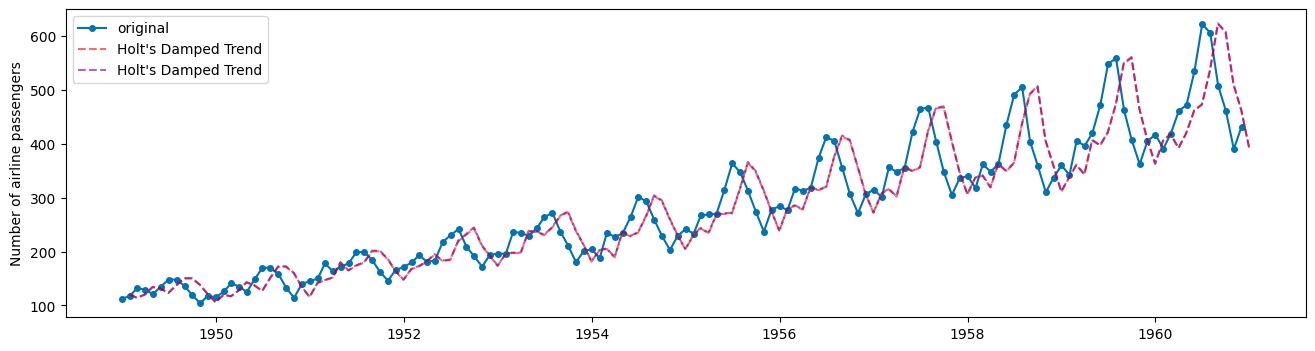

In [9]:
fig, ax = plot_series(y, labels=["original"])
ax.plot(y_hdt_a, color="red", linestyle="--", alpha=0.6,label="Holt's Damped Trend")
ax.plot(y_hdt_m, color="purple", linestyle="--", alpha=0.6,label="Holt's Damped Trend")
plt.legend()
plt.show()

### II.5.C. Holt-Winters' seasonal method

Holt (1957) and Winters (1960) extended Holt’s method to capture seasonality. This method adds a third smoothing parameter, $\gamma$ (gamma), for the seasonal component:


##### Addititve trend and seassonality

- Level: $l_t = \alpha (y_t-s_{t-m}) + (1-\alpha)(l_{t-1} + b_{t-1})$
- Trend: $b_t = \beta(l_t - l_{t-1}) + (1-\beta^*)b_{t-1}$
- Seasonal: $s_t = \gamma(y_t-l_t) + (1-\gamma)s_{t-m}$
- Forecast: $\hat{y}_{t+h|t} = l_t + h \, b_t + s_{t-m+h}$

In [10]:
y = load_airline()

fh = ForecastingHorizon(y.index, is_relative=False)
forecaster = ExponentialSmoothing(trend="add", seasonal="add")

forecaster.fit(y)
y_hws_tasa = forecaster.predict(fh)

forecaster._fitted_forecaster._results._params_formatted

,name,param,optimized
smoothing_level,alpha,2.525894e-01,True
smoothing_trend,beta,9.491666e-09,True
smoothing_seasonal,gamma,7.474106e-01,True
initial_level,l.0,1.184191e+02,True
initial_trend,b.0,2.594768e+00,True
initial_seasons.0,s.0,-9.013070e+00,True
initial_seasons.1,s.1,-3.437147e+00,True
initial_seasons.2,s.2,9.047624e+00,True
initial_seasons.3,s.3,3.804818e+00,True
initial_seasons.4,s.4,-4.937332e+00,True


##### Additive trend and multiplicative seassonality:

- Level: $l_t = \alpha \frac{y_t}{s_{t-m}} + (1-\alpha)(l_{t-1} + b_{t-1})$
- Trend: $b_t = \beta(l_t - l_{t-1}) + (1-\beta^*)b_{t-1}$
- Seasonal: $s_t = \gamma\frac{y_t}{l_t} + (1-\gamma)s_{t-m}$
- Forecast: $\hat{y}_{t+h|t} = (l_t + h \, b_t)\, s_{t-m+h}$



In [11]:
y = load_airline()

fh = ForecastingHorizon(y.index, is_relative=False)
forecaster = ExponentialSmoothing(trend="add", seasonal="mul")

forecaster.fit(y)
y_hws_tasm = forecaster.predict(fh)

forecaster._fitted_forecaster._results._params_formatted

,name,param,optimized
smoothing_level,alpha,3.185975e-01,True
smoothing_trend,beta,3.102411e-08,True
smoothing_seasonal,gamma,6.013647e-01,True
initial_level,l.0,1.011377e+02,True
initial_trend,b.0,2.378082e+00,True
initial_seasons.0,s.0,1.076370e+00,True
initial_seasons.1,s.1,1.131983e+00,True
initial_seasons.2,s.2,1.249986e+00,True
initial_seasons.3,s.3,1.192411e+00,True
initial_seasons.4,s.4,1.113149e+00,True


In [ ]:
fig, ax = plot_series(y, labels=["original"])
ax.plot(y_hws_tasa, color="red", linestyle="--", alpha=0.6,label="HW TASA")
ax.plot(y_hws_tasm, color="purple", linestyle="--", alpha=0.6,label="HW TASM")
plt.legend()
plt.show()

### II.5.C. The _Theta_ Method

Introduced by [Vassilios Assimakopoulos and Konstadinos Nikolopoulos in 2000](https://www.sciencedirect.com/science/article/pii/S0169207000000662), is a simple yet remarkably effective forecasting technique that has performed very well in forecasting competitions. 

It is based on the concept of decomposing a time series by modifying its local curvature.

The core idea is to decompose the original time series into two "Theta-lines":

1.  **The trend line ($\theta=0$)**: This line captures the long-term, linear trend of the data. It's essentially the result of a simple linear regression on the time series. Its forecast is a straightforward linear extrapolation.

2.  **The exaggerated line ($\theta=2$)**: This line "exaggerates" the local curvature of the original series by doubling it. The forecasting for this modified line is then done using **Simple Exponential Smoothing (SES)**.

The final Theta forecast is the simple average of the forecasts produced by these two lines.

#### Relationship to SSE

The final combined forecast of the Theta method can be shown to be equivalent to **SSE with a drift term**. It effectively captures both a global trend (the drift) and a smoothed local level (from the SES component), making it a very robust benchmark model.

#### Example with probabilistic forecast

In [ ]:
from sktime.datasets import load_airline
from sktime.forecasting.theta import ThetaForecaster

y = load_airline()

forecaster = ThetaForecaster(sp=12)
forecaster.fit(y, fh=range(1,12))

coverage = 0.9
y_theta_intervals = forecaster.predict_interval(coverage=coverage)
y_pred = forecaster.predict()

In [ ]:
fig, ax = plot_series(y, y_pred, labels=["y", "y_pred"], pred_interval=y_theta_intervals)
ax.legend()
plt.show()